Agentic AI Workflow for AI OPS


In [ ]:

!pip install -q langchain langchain-openai langgraph scikit-learn pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.5 MB/s eta 0:00:00


In [ ]:

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langgraph.graph import StateGraph
from sklearn.ensemble import IsolationForest
import pandas as pd
from pydantic import BaseModel
from typing import List, Set, Optional, Any
import pickle
from langgraph.graph import END


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class AIOpsState(BaseModel):
    raw_data: Optional[pd.DataFrame] = None
    chat_history: List[dict] = []
    seen_anomalies: Set[str] = set()
    anomalies: Optional[str] = None
    llm: Optional[Any] = None
    remediation_plan: Optional[str] = None

    class Config:
        arbitrary_types_allowed = True


In [ ]:

def map_source_to_column(source):
    source = str(source).lower()
    if "cpu" in source:
        return "cpu"
    elif "memory" in source:
        return "memory"
    elif "disk" in source:
        return "disk"
    return "other"

import re

def extract_metric_value(row):
    try:
        text = str(row["AlertDescription"])
        match = re.search(r'(\d+(\.\d+)?)\s*%', text)
        return float(match.group(1)) if match else None
    except:
        return None


In [ ]:
alerts_path = "/content/drive/MyDrive/alerts.csv"

In [ ]:

def generate_metrics():
    df = pd.read_csv(alerts_path, encoding="ISO-8859-1")
    df["Metric"] = df["Source"].apply(map_source_to_column)
    df["Usage"] = df.apply(extract_metric_value, axis=1)
    df["AlertTime"] = pd.to_datetime(df["AlertTime"], errors='coerce')
    df["State"] = df["Severity"].apply(lambda x: "Critical" if x == 1 else "Warning")
    df.dropna(subset=["Usage", "AlertTime", "Metric"], inplace=True)
    return df


In [ ]:
def detect_anomalies(df):

    pivot_df = df.pivot_table(index="AlertTime", columns="Metric", values="Usage", aggfunc="mean").sort_index()


    # Drop columns where all values are NaN
    pivot_df.dropna(how='all', axis=1, inplace=True)

    if pivot_df.empty or pivot_df.shape[1] == 0:
        print("---- No valid metric data to run anomaly detection.")
        return "No valid metric data to analyze."

    # Fill remaining NaNs with the column mean
    pivot_df = pivot_df.fillna(pivot_df.mean())

    print("pivot: ",pivot_df.shape)
    print(pivot_df.columns.tolist())

    # Isolation Forest
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(pivot_df)
    pivot_df["anomaly"] = model.predict(pivot_df)

    anomalous_times = pivot_df[pivot_df["anomaly"] == -1].index
    anomaly_df = df[df["AlertTime"].isin(anomalous_times)][["AlertTime", "Host", "Metric", "Usage", "State", "AlertDescription"]]

    return anomaly_df.to_string(index=False) if not anomaly_df.empty else "No anomalies detected."



In [ ]:

def deduplicate_event(state: AIOpsState) -> AIOpsState:
    df = generate_metrics()
    df["id"] = df.apply(lambda row: f"{row['Host']}|{row['AlertDescription']}|{row['AlertTime']}", axis=1)
    new_ids = set(df["id"])
    duplicates = new_ids & state.seen_anomalies
    unique_ids = new_ids - state.seen_anomalies
    if not unique_ids:
        state.chat_history.append({"role": "system", "content": " Duplicate alert(s). Skipping."})
    else:
        state.seen_anomalies.update(unique_ids)
        state.chat_history.append({"role": "system", "content": f" {len(unique_ids)} new unique alerts."})
    return state


In [ ]:

def explain_anomalies(state: AIOpsState) -> AIOpsState:
    prompt = PromptTemplate.from_template(
        """Detected anomalies in system metrics:

{anomalies}

Explain possible causes, system impact, and recommended actions."""
    )
    chain = LLMChain(llm=state.llm, prompt=prompt)
    result = chain.run(anomalies=state.anomalies)
    state.chat_history.append({"role": "user", "content": prompt.format(anomalies=state.anomalies)})
    state.chat_history.append({"role": "assistant", "content": result})
    return state

def generate_remediation(state: AIOpsState) -> AIOpsState:
    last_response = state.chat_history[-1]["content"] if state.chat_history else ""
    plan = f" Remediation Plan:\n\n{last_response}\n\n→ Escalate to ops team if auto-heal fails."
    state.chat_history.append({"role": "assistant", "content": plan})
    state.remediation_plan = plan
    return state


In [ ]:
import pandas as pd

df_cleaned = pd.read_csv("/content/drive/MyDrive/alerts_cleaned.csv")
df_cleaned["Usage"] = pd.to_numeric(df_cleaned["Usage"], errors="coerce")
df_cleaned = df_cleaned.dropna(subset=["Usage", "AlertTime"])
print(" Data loaded:", df_cleaned.shape)
df_cleaned.head()


 Data loaded: (1008, 10)


,Host,AlertTime,AlertDescription,AlertClass,AlertType,AlertManager,Source,Status,Severity,Usage
0,AUPRDGLB-HRAPP03,2021-02-06 03:56:00,Memory Utilization is 74% in Warning State on...,OperatingSystem,Server,PlatformMonitoring-Tool,Memory,3,2,74.0
1,USPRDEMPRECWEB03,2021-02-06 05:55:00,Memory Utilization is 70% in Warning State on...,OperatingSystem,Server,PlatformMonitoring-Tool,Memory,1,2,70.0
2,USDEVGLB-HRAPP02,2021-06-02 07:50:00,CPU Utilization is 95% in Critical State on U...,OperatingSystem,Server,PlatformMonitoring-Tool,CPU,1,1,95.0
3,UKDEVPAYROLDBA01,2021-06-02 07:50:00,CPU Utilization is 93% in Critical State on U...,OperatingSystem,Server,PlatformMonitoring-Tool,CPU,1,1,93.0
4,dummy.au-x6.global.com,2021-02-06 10:49:00,Interface Utilization is 75% in Warning State...,network performance,network,network-monitoring-tool,Interface,1,2,75.0


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def arima_baselining(df_cleaned, source_filters=["memory", "cpu"]):
    results = []

    for source_filter in source_filters:
        subset = df[df["Source"].str.lower().str.contains(source_filter, na=False)].copy()

        # Ensure valid datatypes
        subset["AlertTime"] = pd.to_datetime(subset["AlertTime"], errors="coerce")
        subset["Usage"] = pd.to_numeric(subset["Usage"], errors="coerce")
        subset.dropna(subset=["AlertTime", "Usage"], inplace=True)

        if subset.empty:
            print(f" No valid data for {source_filter.upper()}")
            continue

        # Resample to hourly average
        ts = subset.set_index("AlertTime").resample("H")["Usage"].mean().fillna(method="ffill")

        if len(ts) < 10:
            print(f" Not enough data points for {source_filter.upper()} (found {len(ts)}).")
            continue

        try:
            model = ARIMA(ts, order=(2, 1, 2))
            fit = model.fit()
            forecast = fit.predict(start=0, end=len(ts)-1)
            residuals = ts - forecast
            anomalies = residuals[np.abs(residuals) > 1.5 * residuals.std()]

            for t in anomalies.index:
                results.append(f"{source_filter.upper()} baseline deviation at {t}")
        except Exception as e:
            print(f" ARIMA modeling failed for {source_filter.upper()}: {e}")

    return results



In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def visualize_and_evaluate_arima(df, source_filter):
    subset = df[df["Source"].str.lower().str.contains(source_filter)].copy()
    subset["AlertTime"] = pd.to_datetime(subset["AlertTime"], errors="coerce")
    ts = subset.set_index("AlertTime").resample("h")["Usage"].mean().fillna(method="ffill")

    if len(ts) < 10:
        return f" Not enough data for {source_filter.upper()}."

    model = ARIMA(ts, order=(2, 1, 2))
    fit = model.fit()
    forecast = fit.predict(start=0, end=len(ts)-1)
    forecast = pd.Series(forecast.values, index=ts.index, name="Forecast").astype(float)
    ts = ts.astype(float)

    residuals = ts - forecast
    r2 = r2_score(ts, forecast)
    rmse = np.sqrt(mean_squared_error(ts, forecast))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(ts.index, ts, label="Actual", color="blue")
    plt.plot(ts.index, forecast, label="Forecast", color="orange")
    band = 1.5 * residuals.std()
    plt.fill_between(ts.index, forecast - band, forecast + band, color="gray", alpha=0.2, label="Threshold Band")
    plt.title(f"{source_filter.upper()} - ARIMA Forecast\nR²: {r2:.4f}  RMSE: {rmse:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Usage")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"source": source_filter.upper(), "r2": r2, "rmse": rmse}



/tmp/ipython-input-13-3044878693.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = subset.set_index("AlertTime").resample("h")["Usage"].mean().fillna(method="ffill")


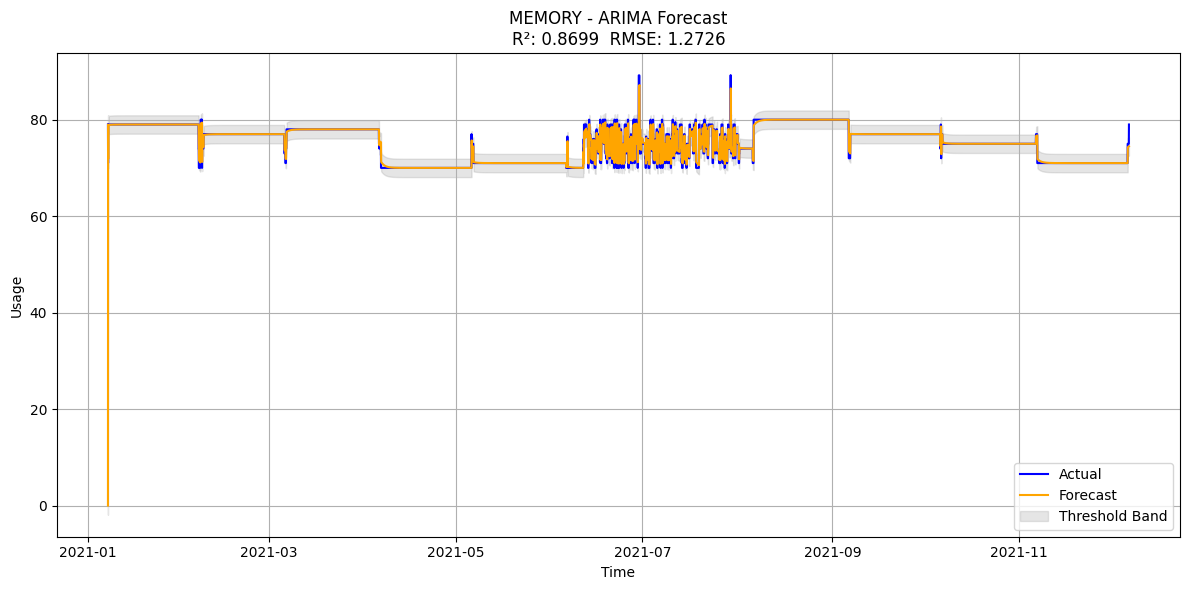

/tmp/ipython-input-13-3044878693.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = subset.set_index("AlertTime").resample("h")["Usage"].mean().fillna(method="ffill")


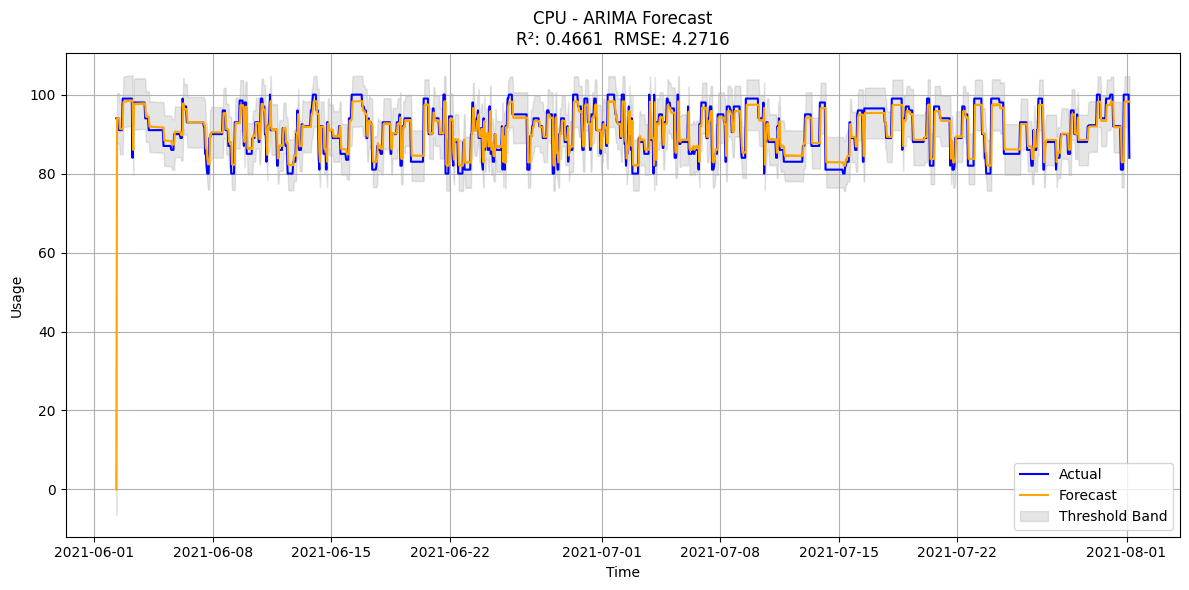

({'source': 'MEMORY',
  'r2': 0.869871121398047,
  'rmse': np.float64(1.272598593543709)},
 {'source': 'CPU',
  'r2': 0.46607870340768875,
  'rmse': np.float64(4.27156936851952)})

In [ ]:
# Run for memory and cpu
results_memory = visualize_and_evaluate_arima(df_cleaned, "memory")
results_cpu = visualize_and_evaluate_arima(df_cleaned, "cpu")

results_memory, results_cpu


In [ ]:
def automated_baselining(state: AIOpsState) -> AIOpsState:
    if state.raw_data is None or state.raw_data.empty:
        print("⚠️ No raw data found for baselining.")
        return state

    df = state.raw_data
    baseline_df = arima_baselining(df)

    if not baseline_df.empty:
        state.anomalies = baseline_df.to_string(index=False)
    else:
        state.anomalies = "No anomalies detected."

    return state


In [ ]:

builder = StateGraph(state_schema=AIOpsState)
builder.add_node("deduplication", deduplicate_event)
builder.add_node("explanation", explain_anomalies)
builder.add_node("automated_baselining", automated_baselining)
builder.add_node("remediation", generate_remediation)
builder.set_entry_point("automated_baselining")
builder.add_edge("automated_baselining", "deduplication")
builder.add_edge("deduplication", "explanation")
builder.add_edge("explanation", "remediation")
builder.add_edge("remediation", END)

graph = builder.compile()


In [ ]:
from google.colab import userdata
openai_api_key = userdata.get("OPEN_API_KEY")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3, openai_api_key=openai_api_key)

state = AIOpsState(
    chat_history=[],
    seen_anomalies=set(),
    anomalies=None,
    llm=llm,
    remediation_plan=None
)

for i in range(2):
    print(f"\n Run {i+1}")
    df = generate_metrics()
    state.anomalies = detect_anomalies(df)
    result = graph.invoke(state)
    state = AIOpsState(**result)


    print("\n📋 Chat History (Last 4 messages):")
    for msg in state.chat_history[-4:]:
        print(f"[{msg['role'].upper()}]: {msg['content']}\n")

    if state.remediation_plan:
        print(state.remediation_plan)





 Run 1
pivot:  (62, 2)
['memory', 'other']
⚠️ No raw data found for baselining.


/tmp/ipython-input-10-3027720889.py:9: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=state.llm, prompt=prompt)
/tmp/ipython-input-10-3027720889.py:10: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain.run(anomalies=state.anomalies)



📋 Chat History (Last 4 messages):
[SYSTEM]:  62 new unique alerts.

[USER]: Detected anomalies in system metrics:

          AlertTime                   Host Metric  Usage   State                                                 AlertDescription
2021-06-06 04:26:00 dummy.uk-x3.global.com  other   70.0 Warning Interface Utilization is  70% in Warning State on 172.28.176.192
2021-07-06 05:17:00 dummy.us-x1.global.com  other   77.0 Warning     Interface Utilization is  77% in Warning State on 10.10.10.1
2021-08-06 00:10:00 dummy.au-x3.global.com  other   76.0 Warning Interface Utilization is  76% in Warning State on 145.29.175.174
2021-02-07 13:47:00 dummy.us-x4.global.com  other   70.0 Warning     Interface Utilization is  70% in Warning State on 10.10.10.4

Explain possible causes, system impact, and recommended actions.

[ASSISTANT]: Possible causes:
1. Increased network traffic or data transfer on the interfaces leading to higher utilization levels.
2. Configuration issues or mismanag

In [ ]:

# Temporarily remove non-pickleable object
llm_obj = state.llm
state.llm = None

with open("aiops_state.pkl", "wb") as f:
    pickle.dump(state, f)

# Restore LLM to state after saving
state.llm = llm_obj
